# Import Libraries

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset

In [24]:
df = pd.read_csv("Superstore.csv")

# Basic Dataset Info

In [25]:
print("Dataset Info:")
print(df.info())  # Check column data types
print("\nMissing Values:")
print(df.isnull().sum())  # Check for missing values
print("\nDuplicate Entries:", df.duplicated().sum())  # Check for duplicate rows

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64

# Handle Missing Values and Duplicates

In [26]:
df = df.dropna()  # Remove missing values (if any)
df = df.drop_duplicates()  # Remove duplicate rows

# Convert Date Columns to DateTime

In [33]:
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True, errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], dayfirst=True, errors='coerce')

# Feature Engineering (New Columns)

In [34]:
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['DayOfWeek'] = df['Order Date'].dt.dayofweek  # 0 = Monday, 6 = Sunday

#  Save Cleaned Data

In [35]:
df.to_csv("cleaned_superstore.csv", index=False)

# Exploratory Data Analysis (EDA)

## Sales Trend Over Time

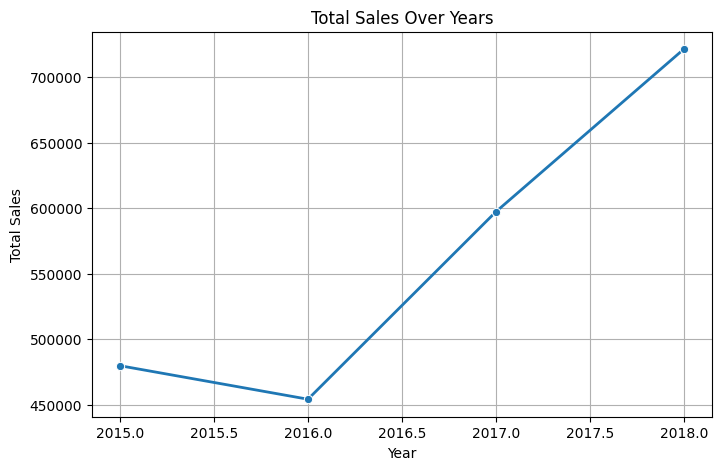

In [36]:
sales_by_year = df.groupby('Year')['Sales'].sum()
plt.figure(figsize=(8, 5))
sns.lineplot(x=sales_by_year.index, y=sales_by_year.values, marker="o", linewidth=2)
plt.title("Total Sales Over Years")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()

## Top 10 States by Sales

/var/folders/2t/h2swbhr56cddcdhwxy8t_k740000gn/T/ipykernel_96412/3734811423.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states.values, y=top_states.index, palette="viridis")


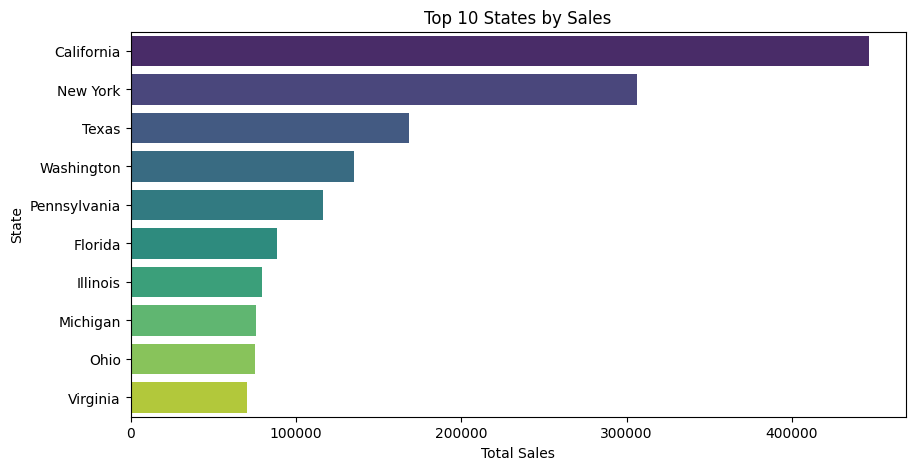

In [37]:
top_states = df.groupby('State')['Sales'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_states.values, y=top_states.index, palette="viridis")
plt.title("Top 10 States by Sales")
plt.xlabel("Total Sales")
plt.ylabel("State")
plt.show()

## Sales by Product Category

/var/folders/2t/h2swbhr56cddcdhwxy8t_k740000gn/T/ipykernel_96412/3273370778.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_sales.index, y=category_sales.values, palette="muted")


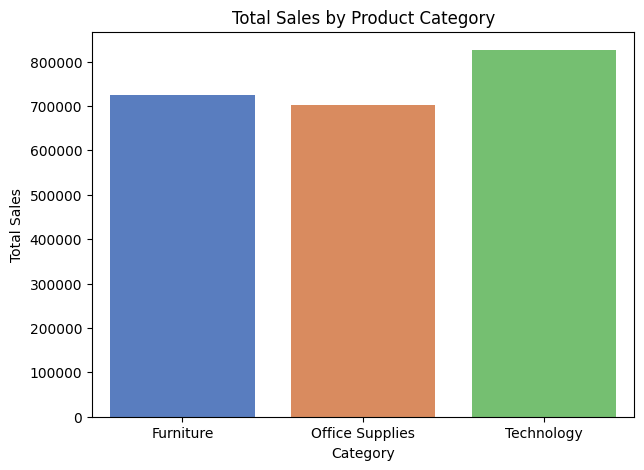

In [38]:
category_sales = df.groupby("Category")["Sales"].sum()
plt.figure(figsize=(7, 5))
sns.barplot(x=category_sales.index, y=category_sales.values, palette="muted")
plt.title("Total Sales by Product Category")
plt.xlabel("Category")
plt.ylabel("Total Sales")
plt.show()

## Sales Distribution by Customer Segment

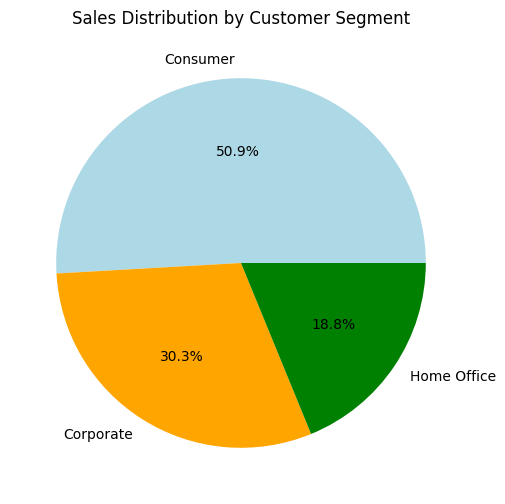

In [39]:
segment_sales = df.groupby("Segment")["Sales"].sum()
plt.figure(figsize=(6, 6))
plt.pie(segment_sales, labels=segment_sales.index, autopct='%1.1f%%', colors=['lightblue', 'orange', 'green'])
plt.title("Sales Distribution by Customer Segment")
plt.show()

# Prepare Data for Forecasting

  Order Date     Sales
0 2015-01-03    16.448
1 2015-01-04   288.060
2 2015-01-05    19.536
3 2015-01-06  4407.100
4 2015-01-07    87.158


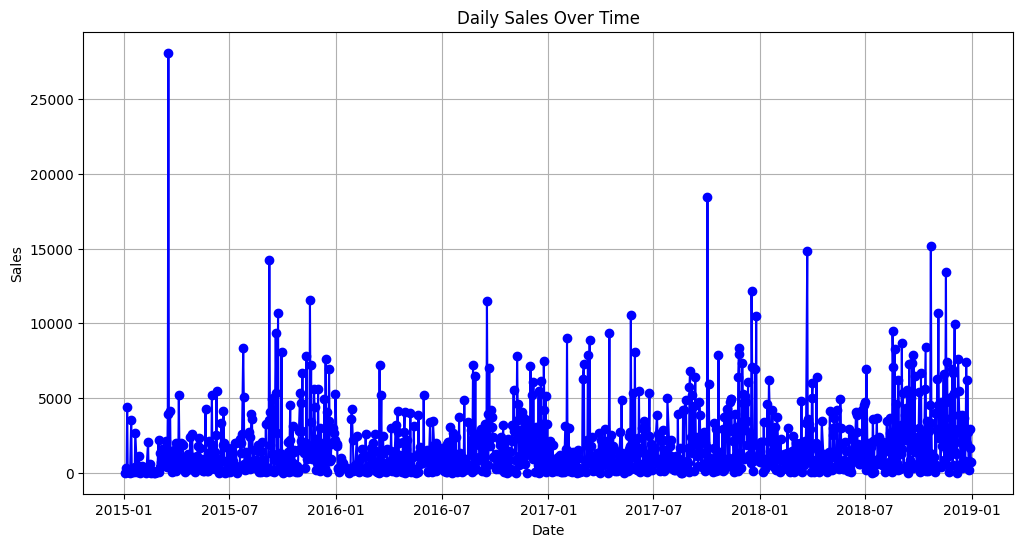

In [43]:
# Aggregate daily sales
df_time_series = df.groupby('Order Date')['Sales'].sum().reset_index()

# Sort by date
df_time_series = df_time_series.sort_values(by="Order Date")

# Display first few rows
print(df_time_series.head())

# Plot Sales Over Time
plt.figure(figsize=(12, 6))
plt.plot(df_time_series['Order Date'], df_time_series['Sales'], linestyle='-', marker="o", color='blue')
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid()
plt.show()

# Check for Stationarity

In [44]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(df_time_series['Sales'])

print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

# If p-value > 0.05, data is non-stationary
if adf_test[1] > 0.05:
    print("The time series is non-stationary, differencing needed.")
else:
    print("The time series is stationary, ready for modeling.")

ADF Statistic: -5.712554167940092
p-value: 7.243309858006204e-07
The time series is stationary, ready for modeling.


# Build ARIMA Forecasting Model

In [46]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Train Auto ARIMA Model
auto_arima_model = auto_arima(df_time_series['Sales'], seasonal=False, trace=True)

# Extract best parameters
best_order = auto_arima_model.order
print("Best ARIMA Order:", best_order)

# Train Final ARIMA Model
arima_model = ARIMA(df_time_series['Sales'], order=best_order)
arima_result = arima_model.fit()

# Predict next 30 days
forecast_steps = 30
forecast = arima_result.forecast(steps=forecast_steps)

# Plot Forecast
plt.figure(figsize=(12, 6))
plt.plot(df_time_series['Order Date'], df_time_series['Sales'], label="Actual Sales", color="blue")
plt.plot(pd.date_range(start=df_time_series['Order Date'].max(), periods=forecast_steps, freq='D'),
         forecast, label="Forecasted Sales", linestyle="dashed", color="red")
plt.title("Sales Forecast for Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.show()


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject